<a href="https://colab.research.google.com/github/arrovvx/stockpredict/blob/master/stockpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

import math
import numpy as np
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv('https://raw.githubusercontent.com/arrovvx/stockpredict/master/AAPL.csv',index_col=0, parse_dates=['Date'], date_parser=dateparse) 
start = datetime.datetime(2010, 9, 6)
end = datetime.datetime(2019, 9, 6)

#df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-30,210.160004,210.449997,207.199997,208.740005,208.740005,21143400
2019-09-03,206.429993,206.979996,204.220001,205.699997,205.699997,20023000
2019-09-04,208.389999,209.479996,207.320007,209.190002,209.190002,19188100
2019-09-05,212.000000,213.970001,211.509995,213.279999,213.279999,23913700
2019-09-06,214.050003,214.419998,212.509995,213.259995,213.259995,19350800


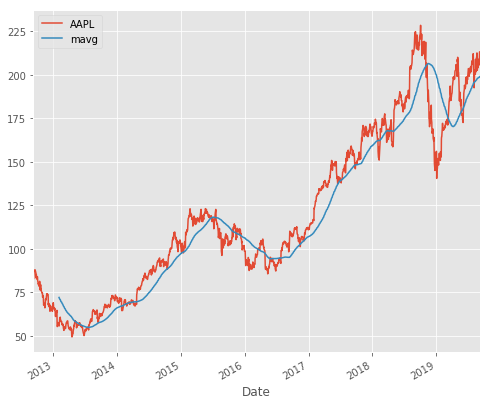

In [148]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [150]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
print(X.shape)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
print(X_lately.shape)
X = X[:-forecast_out]
print(X.shape)
# Separate label and identify it as y
y = np.array(dfreg['label'])
print(y.shape)
y = y[:-forecast_out]
print(y.shape)

(1759, 4)
(18, 4)
(1741, 4)
(1759,)
(1741,)


In [151]:
X_train = X
y_train = y

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [152]:
X_test = X
y_test = y

confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print(confidencereg)
print(confidencepoly2)
print(confidencepoly3)
print(confidenceknn)
# results
#('The linear regression confidence is ', 0.96399641826551985)
#('The quadratic regression 2 confidence is ', 0.96492624557970319)
#('The quadratic regression 3 confidence is ', 0.9652082834532858)
#('The knn regression confidence is ', 0.92844658034790639)

0.9645419903913776
0.9662446484875699
0.9685534928409095
0.9826714115706592


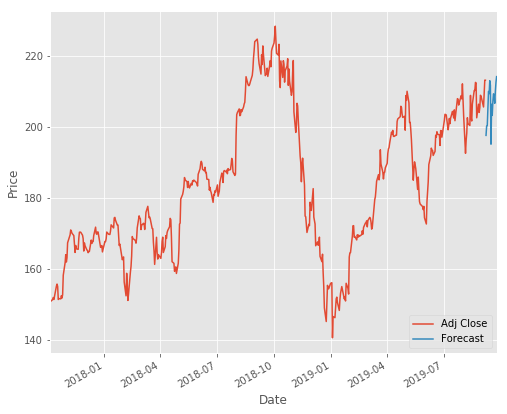

In [139]:
forecast_set = clfpoly2.predict(X_lately)
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

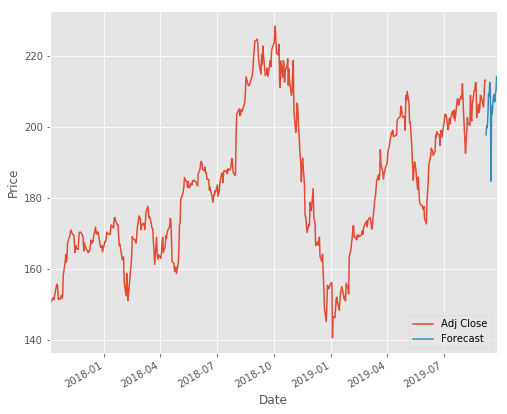

In [146]:
forecast_set = clfpoly3.predict(X_lately)
dfreg['Forecast'] = np.nan

last_date3 = dfreg.iloc[-1].name
last_unix3 = last_date3
next_unix3 = last_unix3 + datetime.timedelta(days=1)

for i in forecast_set:
    next_date3 = next_unix3
    next_unix3 += datetime.timedelta(days=1)
    dfreg.loc[next_date3] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

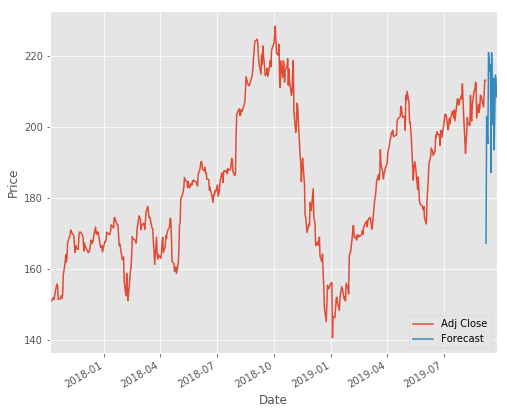

In [153]:
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()